In [4]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import pandas as pd
import matplotlib.pyplot as plt
import joblib
import time
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [13]:
###############################################################################
# 1. Data preparation
###############################################################################
def create_sequences(data, window_size):
    """
    Convert a multivariate sequence into samples of shape (window_size, n_features).
    The target is the last column (log_beta).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :-1])  # use first 6 features as input
        y.append(data[i + window_size, -1])         # predict normalized log_beta
    
    return np.array(X), np.array(y)


def load_and_prepare_data(df_dir, seeds_number, window_size, 
                          scaler = None, is_filename=False):
    """
    Loads CSV files, applies shift(-2) for 'prev_I', computes log(Beta) for 'log_beta',
    and fits a global scaler on all 7 columns.
    Returns training sequences, targets, and the scaler.
    """
    if scaler == None:
        train_df = []
        
        # First pass: collect data for scaling
        for i in seeds_number:
            try:
                if is_filename:
                    seed_df = pd.read_csv(df_dir+i.split('\\')[-1])
                else:
                    seed_df = pd.read_csv(df_dir+f'seir_seed_{i}.csv')
                    
                seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
                seed_df['log_beta'] = np.log(seed_df['Beta'] + 1e-7) 
                features = seed_df[['log_beta']].shift(np.arange(window_size+1)
                                                      ).dropna().values
                train_df.append(features)
                
            except Exception as e:
                print(f"Skipping seed {i}: {str(e)}")
                continue

        scaler = StandardScaler()
        if train_df:
            scaler.fit(np.concatenate(train_df))
        else:
            raise ValueError("No data collected for scaling. Please check your input files.")

    # Second pass: create training sequences
    all_X, all_y = [], []
    for i in seeds_number:
        try:
            if is_filename:
                seed_df = pd.read_csv(df_dir+i.split('\\')[-1])
            else:
                seed_df = pd.read_csv(df_dir+f'seir_seed_{i}.csv')
            seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
            seed_df['log_beta'] = np.log(seed_df['Beta'] + 1e-7) 

            features = seed_df[['log_beta']].values
            features = seed_df[['log_beta']].shift(np.arange(window_size+1)
                                                      ).dropna().values
            
            scaled_features = scaler.transform(features)
            X, y = create_sequences(scaled_features, window_size)
            all_X.append(X)
            all_y.append(y)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    if not all_X or not all_y:
        raise ValueError("No valid training data found. Please check your input files.")

    return np.concatenate(all_X), np.concatenate(all_y), scaler

###############################################################################
# 2. Simplified model architecture with Grid search hyperparameters
###############################################################################
def build_lstm_model(window_size, n_features,
                     lstm_units1=64, lstm_units2=64,
                     dropout_rate1=0.2, dropout_rate2=0.3,
                     optimizer='rmsprop'):
    """
    Builds an LSTM model using the grid search best hyperparameters:
      - First LSTM layer units: 64 with recurrent dropout of 0.2
      - Second LSTM layer units: 64 with dropout of 0.3
      - Optimizer: rmsprop
    """
    inputs = Input(shape=(window_size, n_features))
    x = LSTM(lstm_units1, return_sequences=True, recurrent_dropout=dropout_rate1)(inputs)
    x = Dropout(dropout_rate1)(x)
    x = LSTM(lstm_units2, return_sequences=False)(x)
    x = Dropout(dropout_rate2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')
    return model

###############################################################################
# 3. Enhanced training configuration
###############################################################################
def lr_scheduler(epoch):
    """
    Applies learning rate decay after 20 epochs.
    """
    initial_lr = 0.001
    decay = 0.1 if epoch > 30 else 1.0
    return initial_lr * decay


def train_lstm_model(X_train, y_train, X_val, y_val, window_size):
    """
    Builds and trains the LSTM model with early stopping and a learning rate scheduler.
    """
    model = build_lstm_model(window_size, X_train.shape[2])
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
        verbose=1
    )
    return model, history

###############################################################################
# 4. Training pipeline
###############################################################################
def train_and_save_model(seeds_dir, df_seeds, 
                         model_save_path, scaler_save_path, 
                         window_size, is_filename=False):
    print(f"Training LSTM model on seeds...")
    start_time = time.time()
    if is_filename:
        col = 'file'
    else:
        col='seed_number'
    seeds_train = df_seeds[df_seeds.set=='train'][col].values
    X_train, y_train, scaler = load_and_prepare_data(seeds_dir, seeds_train, 
                                                     window_size, None,
                                                    is_filename)
    seeds_val = df_seeds[df_seeds.set=='val'][col].values
    X_val, y_val, _ = load_and_prepare_data(seeds_dir, seeds_val, window_size, 
                                            scaler = scaler,
                                           is_filename = is_filename)
    if len(X_train) == 0:
        raise ValueError("No valid training data found.")
    
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, window_size)
    
    model.save(model_save_path)
    joblib.dump(scaler, scaler_save_path)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f}s")
    
    # Plot training history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, training_time


In [6]:
window_size = 7 

In [14]:
seeds_dir='initial_data/new_ba_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 4

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100


ValueError: Shape must be rank 1 but is rank 2 for '{{node rmsprop_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, data_format="NHWC"](rmsprop_1/Mul, rmsprop_1/Squeeze)' with input shapes: [0,256], [0,256].

In [17]:
seeds_train = df_seeds_n[df_seeds_n.set=='train']['file'].values
X_train, y_train, scaler = load_and_prepare_data(seeds_dir, seeds_train, 
                                                 window_size, None,
                                                True)
seeds_val = df_seeds_n[df_seeds_n.set=='val']['file'].values
X_val, y_val, _ = load_and_prepare_data(seeds_dir, seeds_val, window_size, 
                                        scaler = scaler,
                                       is_filename = True)

In [20]:
seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
seed_df['log_beta'] = np.log(seed_df['Beta'] + 1e-7) 

features = seed_df[['log_beta']].values

scaled_features = scaler.transform(features)
X, y = create_sequences(scaled_features, window_size)

In [37]:
np.array(X)

array([], shape=(149, 4, 0), dtype=float64)

In [42]:
lag = 4
q = seed_df[['log_beta']].shift(np.arange(lag+1)).dropna()
q

,log_beta_0,log_beta_1,log_beta_2,log_beta_3,log_beta_4
4,-8.722744,-8.391383,-7.896989,-7.508292,-7.184974
5,-9.006781,-8.722744,-8.391383,-7.896989,-7.508292
6,-9.239952,-9.006781,-8.722744,-8.391383,-7.896989
7,-9.268698,-9.239952,-9.006781,-8.722744,-8.391383
8,-9.410600,-9.268698,-9.239952,-9.006781,-8.722744
...,...,...,...,...,...
148,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
149,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
150,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
151,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096


In [44]:
q.drop(columns=['log_beta_0']).values.shape

(149, 4)

In [47]:
q['log_beta_0'].values.shape

(149,)

In [25]:
features[:7]

array([[-7.18497369],
       [-7.50829151],
       [-7.89698871],
       [-8.39138295],
       [-8.72274447],
       [-9.0067814 ],
       [-9.23995249]])

In [ ]:
X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :-1])  # use first 6 features as input
        y.append(data[i + window_size, -1]) 

In [48]:
X

array([], shape=(149, 4, 0), dtype=float64)

In [18]:
X_train

array([], shape=(141777, 4, 0), dtype=float64)

In [19]:
y_train

array([ 1.50694901,  1.46912847,  1.39424024, ..., -0.82497109,
       -0.82497109, -0.82497109])

## barabasi-albert

Training LSTM model on seeds...
Epoch 1/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9246 - val_loss: 0.8672 - learning_rate: 0.0010
Epoch 2/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.8683 - val_loss: 0.8316 - learning_rate: 0.0010
Epoch 3/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.8392 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 4/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7855 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 5/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7621 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 6/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7835 - val_loss: 0.7129 - learning_rate: 0.0010
Epoch 7/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7423 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 8/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7092 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 9/100
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6647 - val_loss:

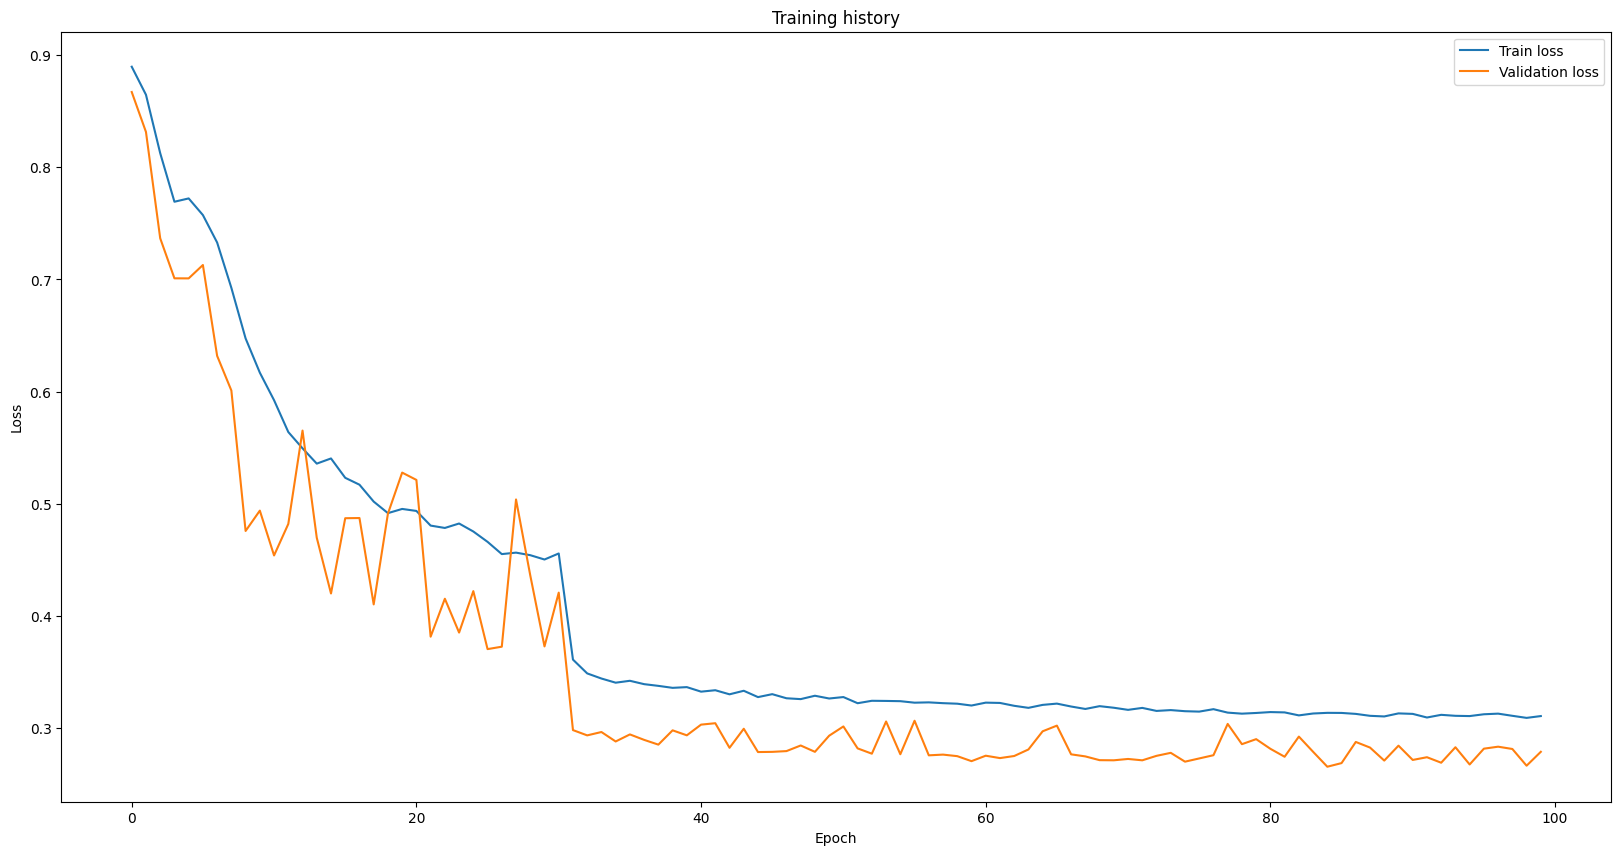

In [4]:
seeds_dir='initial_data/initial_data_ba_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size
    )


Training LSTM model on seeds...
Epoch 1/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8120 - val_loss: 0.7587 - learning_rate: 0.0010
Epoch 2/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.7612 - val_loss: 0.7861 - learning_rate: 0.0010
Epoch 3/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7610 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 4/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.7584 - val_loss: 0.7492 - learning_rate: 0.0010
Epoch 5/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6983 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch 6/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6404 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 7/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6067 - val_loss: 0.5941 - learning_rate: 0.0010
Epoch 8/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.5722 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 9/100
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step 

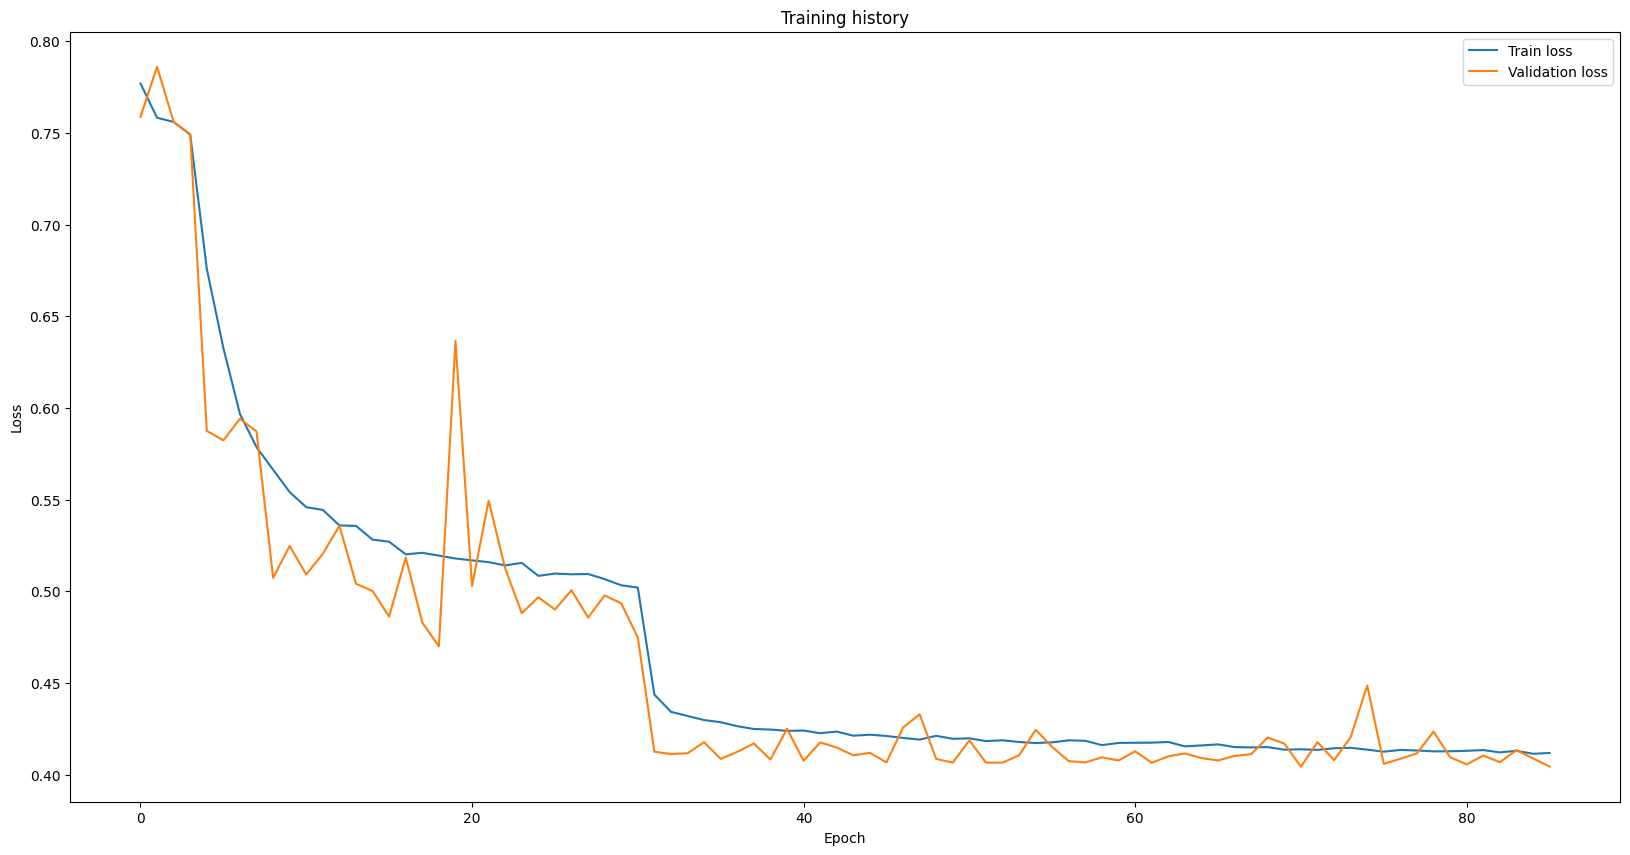

In [4]:
seeds_dir='initial_data/initial_data_r_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size
    )


Training LSTM model on seeds...
Epoch 1/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.8678 - val_loss: 0.8220 - learning_rate: 0.0010
Epoch 2/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8284 - val_loss: 0.8285 - learning_rate: 0.0010
Epoch 3/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8357 - val_loss: 0.8186 - learning_rate: 0.0010
Epoch 4/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8392 - val_loss: 0.8234 - learning_rate: 0.0010
Epoch 5/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8244 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 6/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7878 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 7/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7747 - val_loss: 0.7802 - learning_rate: 0.0010
Epoch 8/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7616 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 9/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step 

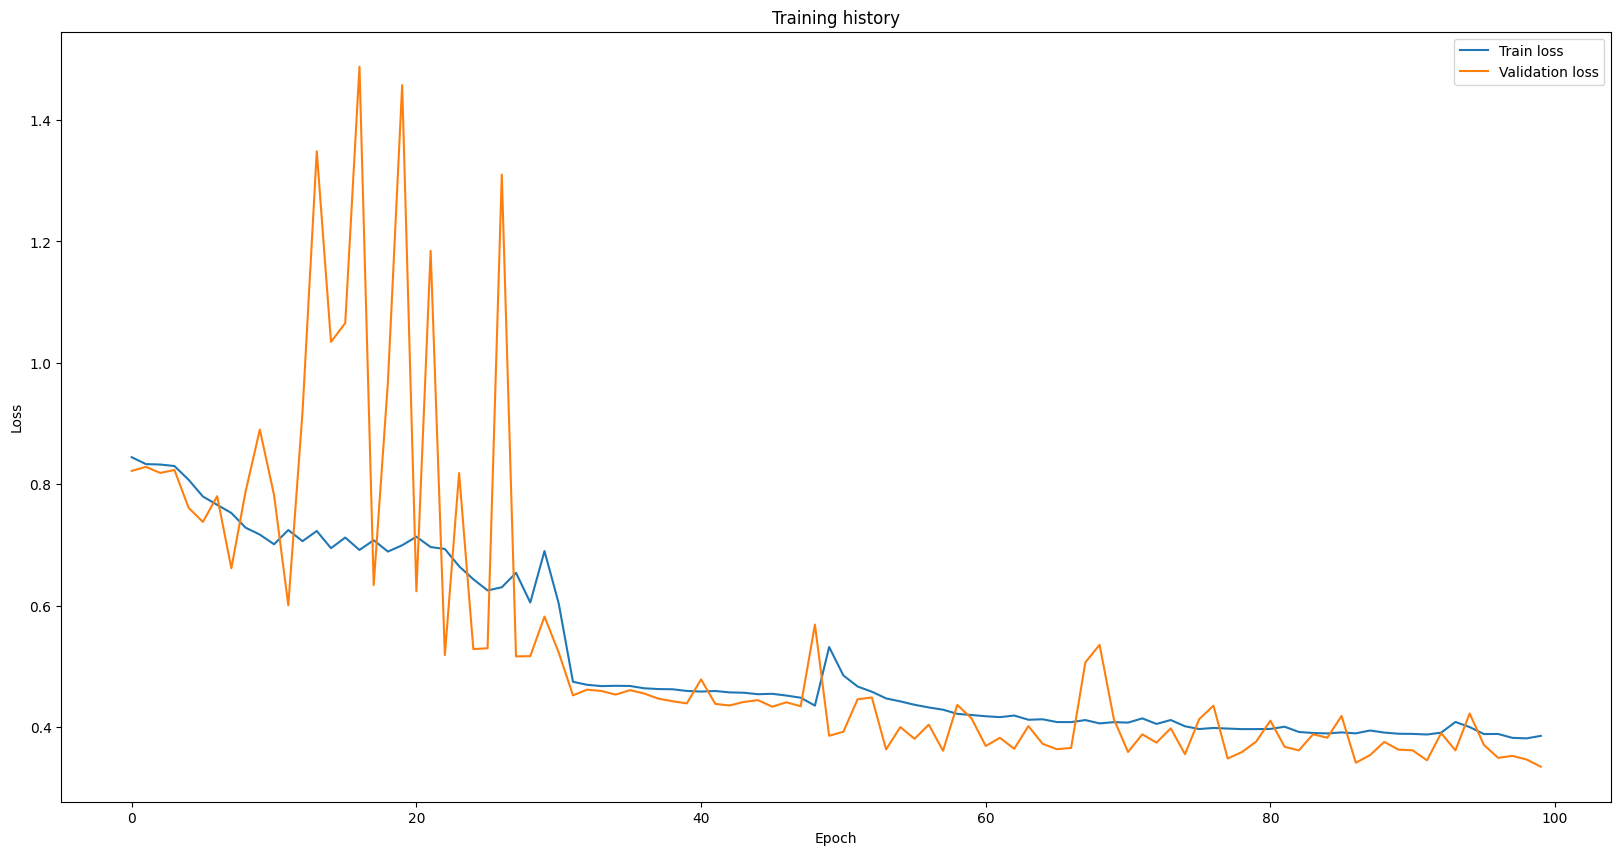

In [5]:
seeds_dir='initial_data/initial_data_r_100000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size
    )


## new

Training LSTM model on seeds...
Epoch 1/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3640 - val_loss: 0.3388 - learning_rate: 0.0010
Epoch 2/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2694 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 3/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2324 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 4/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2174 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 5/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2084 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 6/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2040 - val_loss: 0.2740 - learning_rate: 0.0010
Epoch 7/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2085 - val_loss: 0.2224 - learning_rate: 0.0010
Epoch 8/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2005 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 9/100
836/836 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1947 - val_loss: 

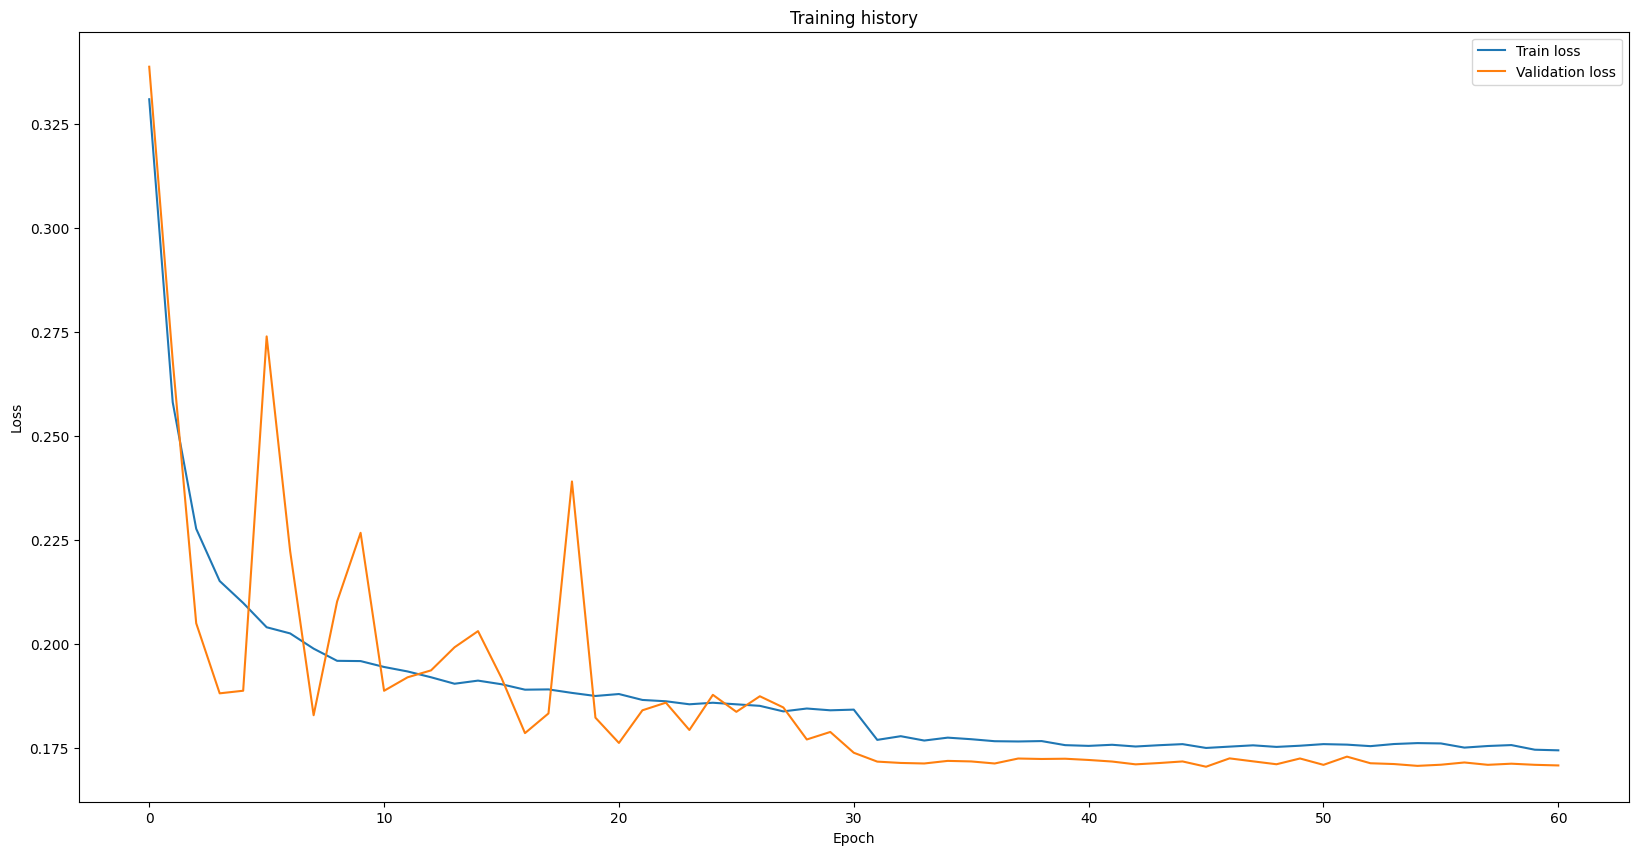

In [4]:
seeds_dir='initial_data/new_ba_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.3144 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 2/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2528 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 3/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2193 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 4/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2052 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 5/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1998 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 6/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1961 - val_loss: 0.1745 - learning_rate: 0.0010
Epoch 7/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1912 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 8/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1865 - val_loss: 0.1698 - learning_rate: 0.0010
Epoch 9/100
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0

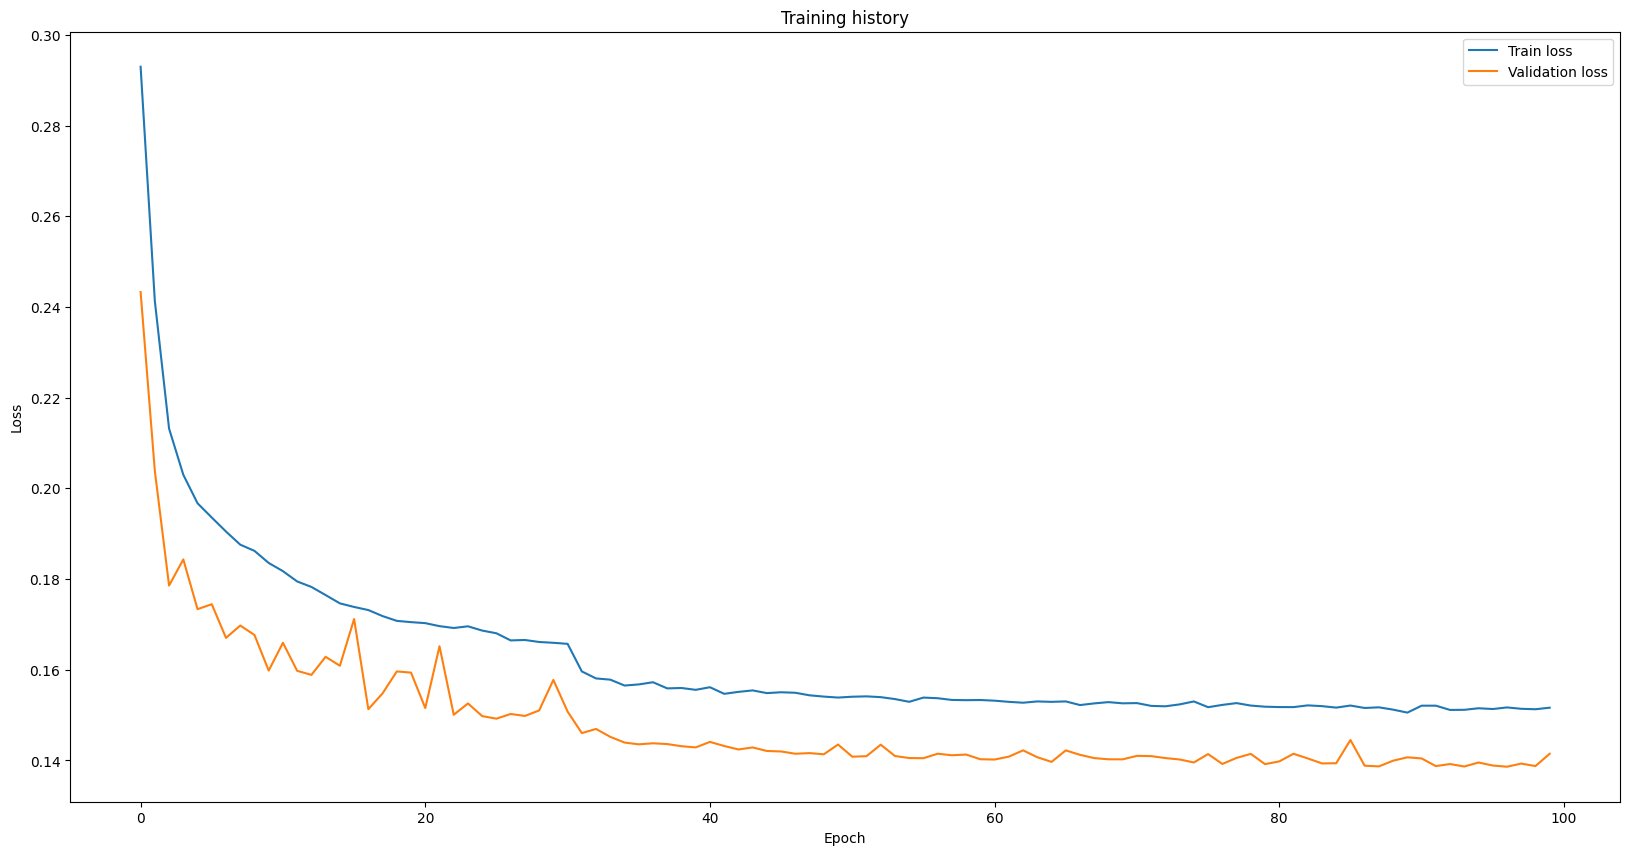

In [5]:
seeds_dir='initial_data/new_ba_50000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.2734 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 2/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.2246 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 3/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1975 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 4/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1890 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 5/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1838 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 6/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1808 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 7/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1772 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 8/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1751 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 9/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step 

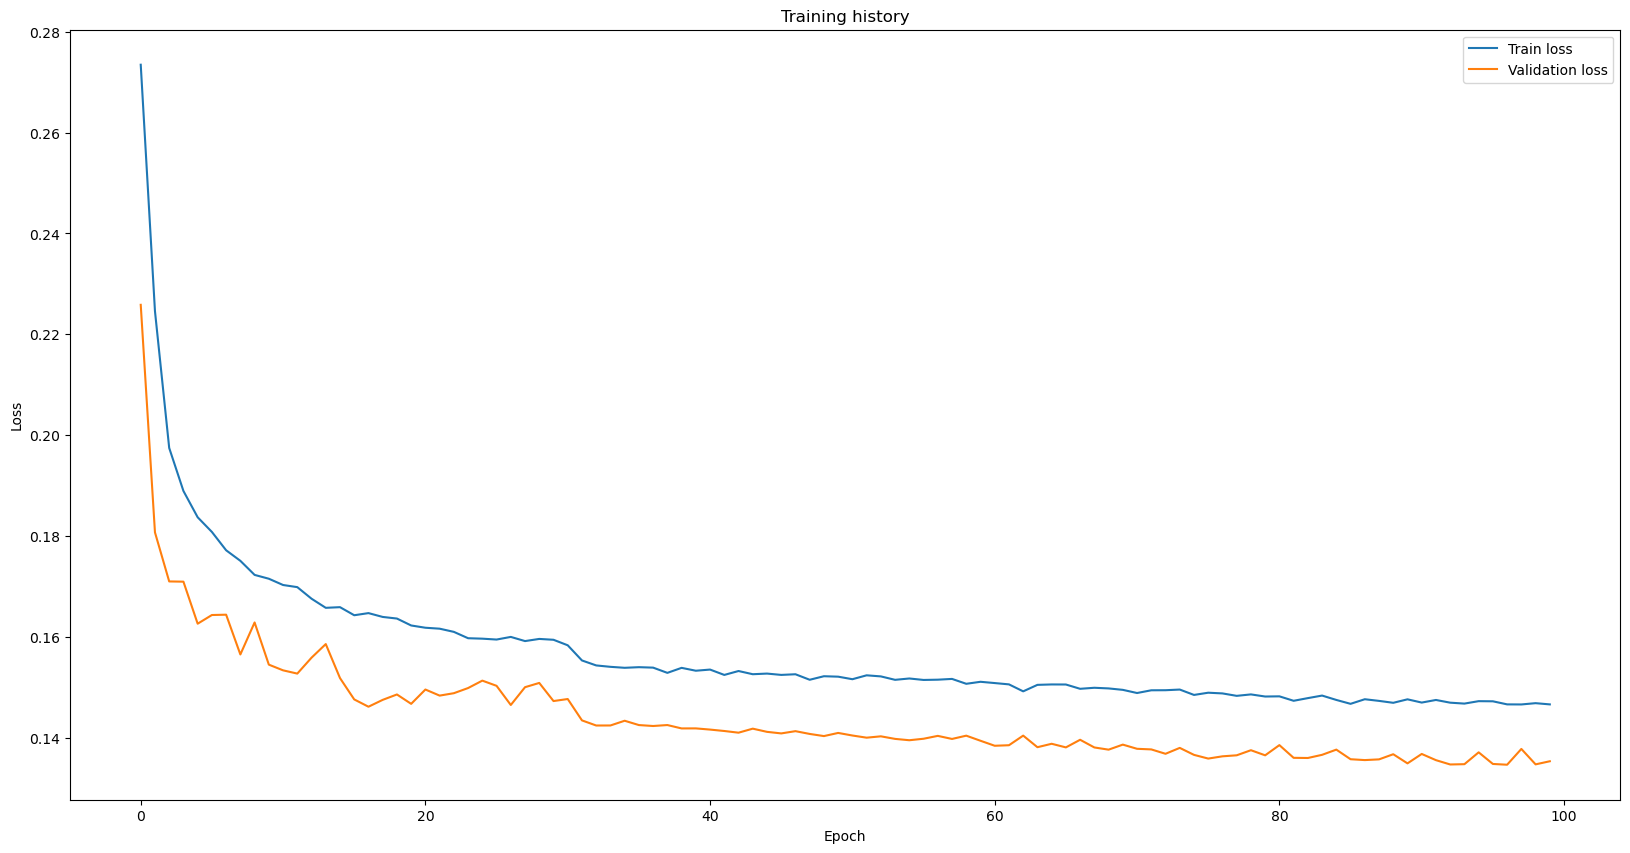

In [7]:
seeds_dir='initial_data/new_ba_100000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7542 - val_loss: 0.5995 - learning_rate: 0.0010
Epoch 2/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5675 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 3/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5006 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 4/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4530 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 5/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4331 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 6/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4290 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 7/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4180 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 8/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4113 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 9/100
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 

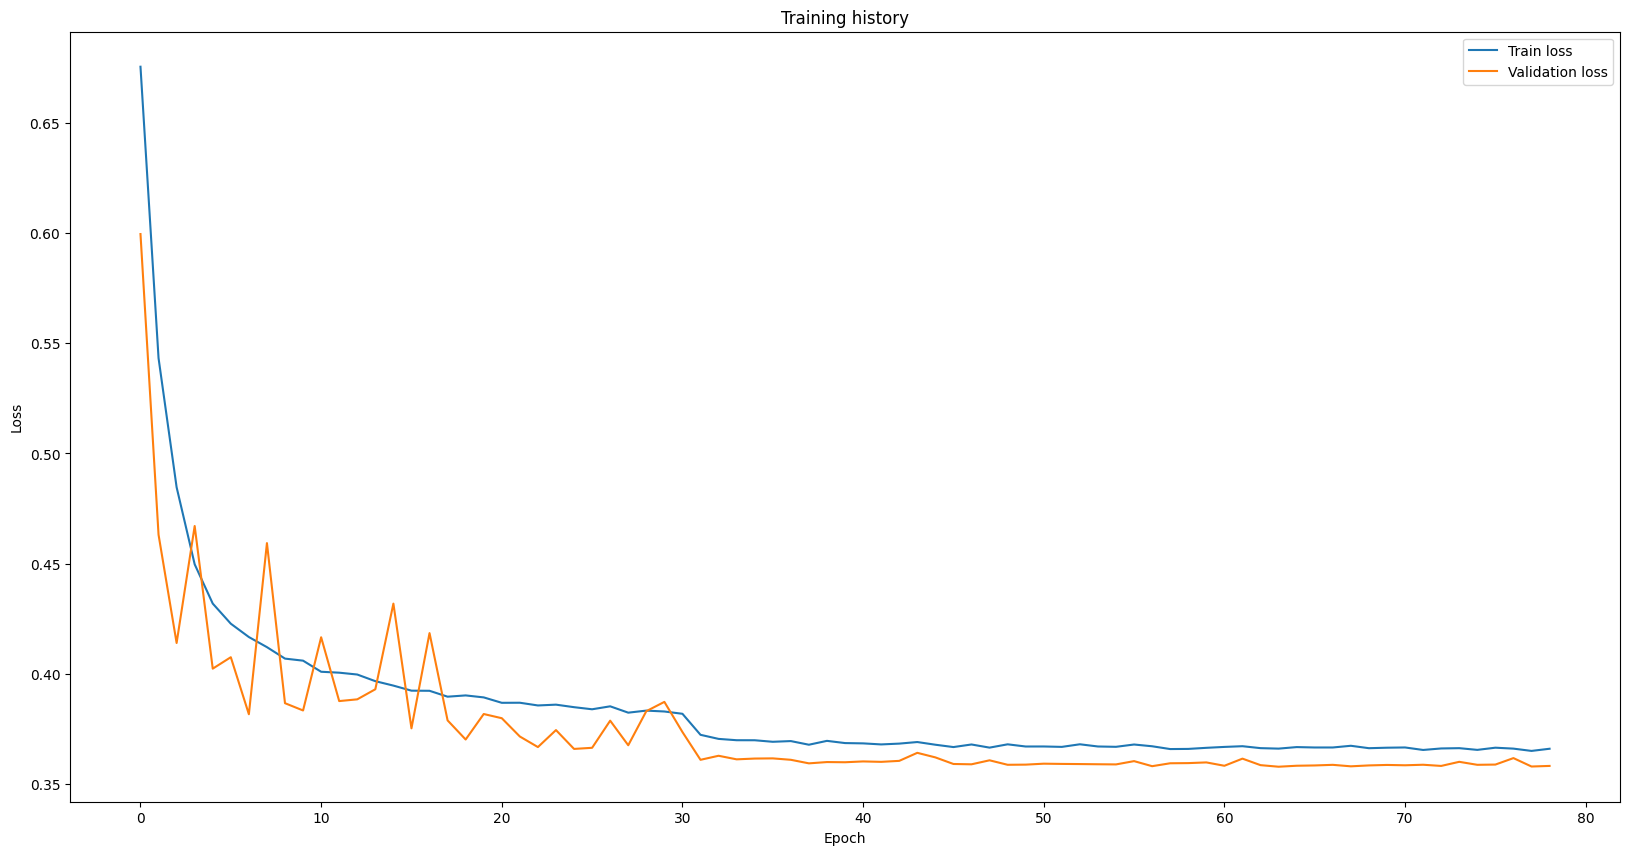

In [6]:
seeds_dir='initial_data/new_r_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.5521 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 2/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.4952 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 3/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.4157 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 4/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.3817 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 5/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.3671 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 6/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.3590 - val_loss: 0.3494 - learning_rate: 0.0010
Epoch 7/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.3506 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 8/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.3454 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 9/100
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step 

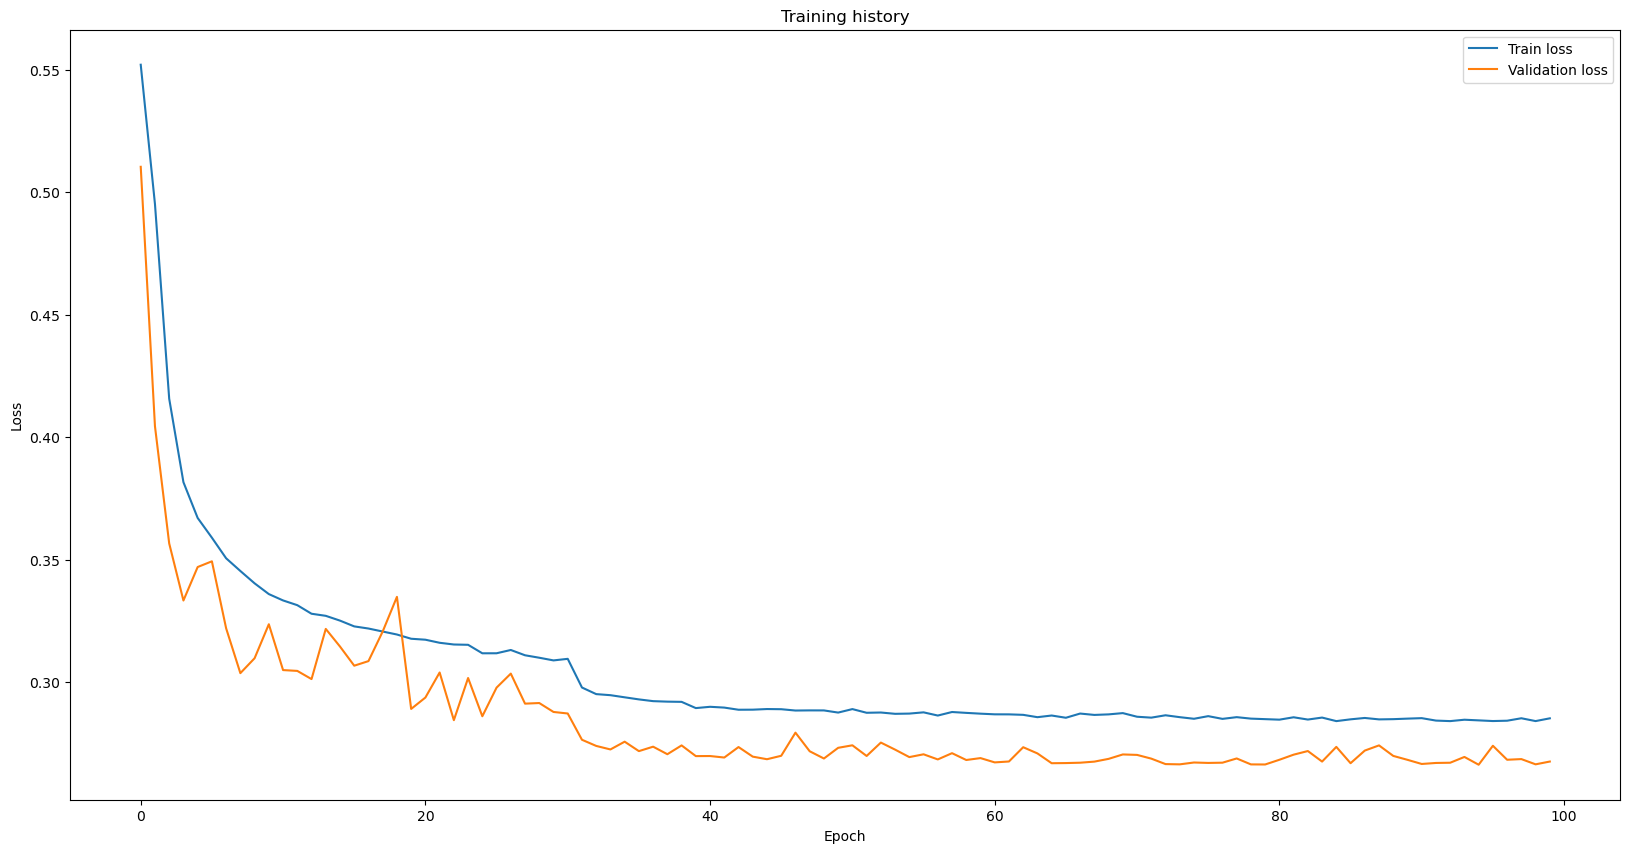

In [8]:
seeds_dir='initial_data/new_r_50000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.5082 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 2/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.4633 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 3/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.3881 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 4/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.3555 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 5/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.3433 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 6/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.3344 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 7/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.3269 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 8/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.3219 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 9/100
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step

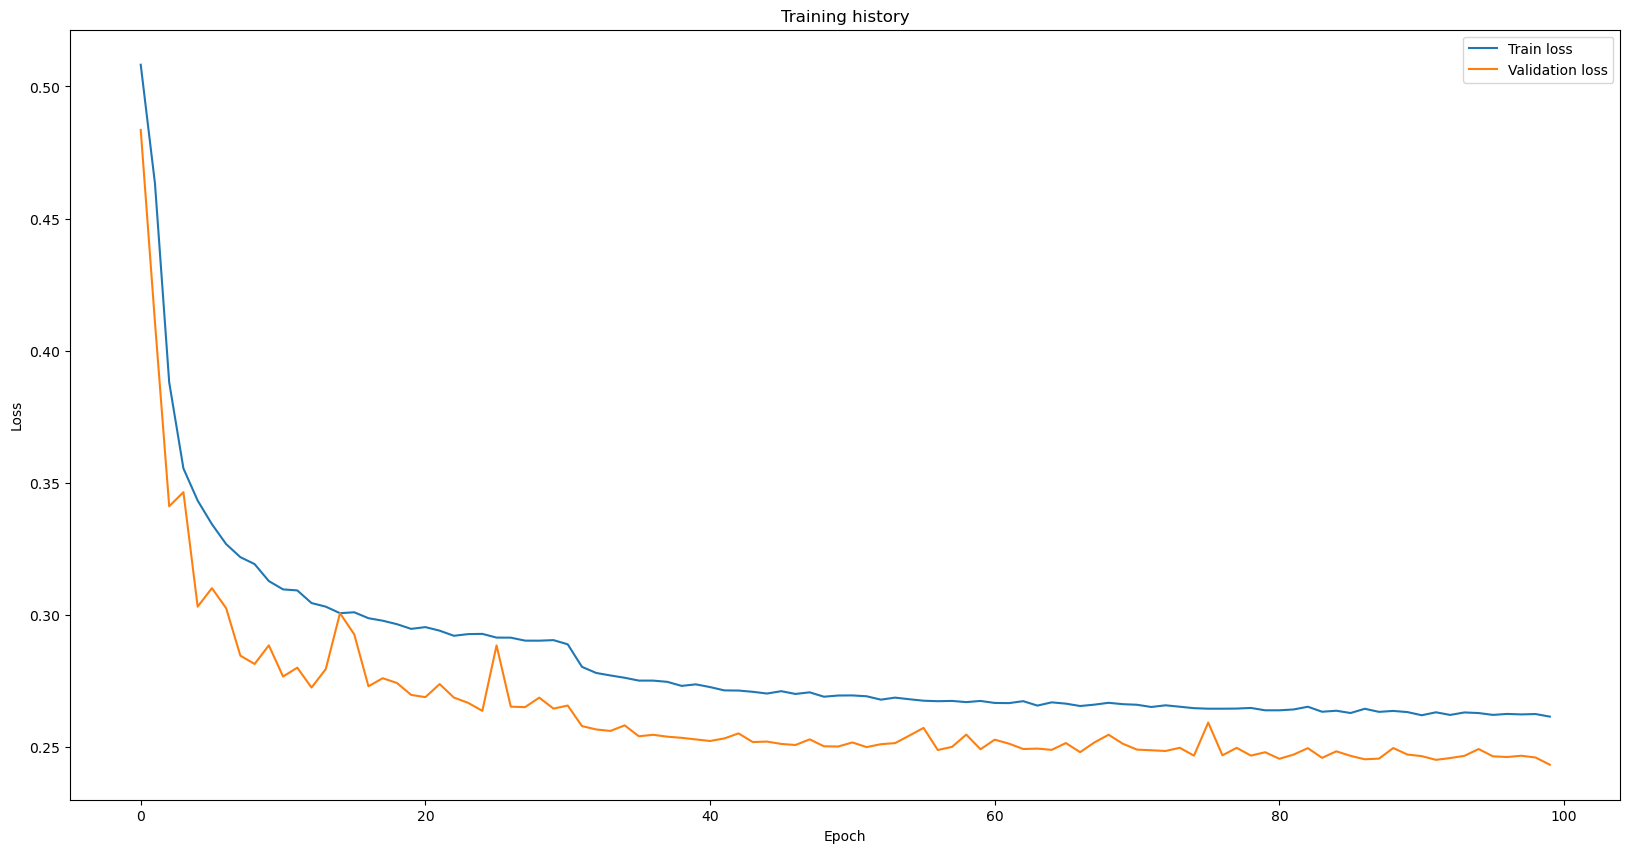

In [9]:
seeds_dir='initial_data/new_r_100000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 0.3253 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 2/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.2434 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 3/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2227 - val_loss: 0.1982 - learning_rate: 0.0010
Epoch 4/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2126 - val_loss: 0.1931 - learning_rate: 0.0010
Epoch 5/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2064 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 6/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2028 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 7/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2004 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 8/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.1983 - val_loss: 0.2015 - learning_rate: 0.0010
Epoch 9/100
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step 

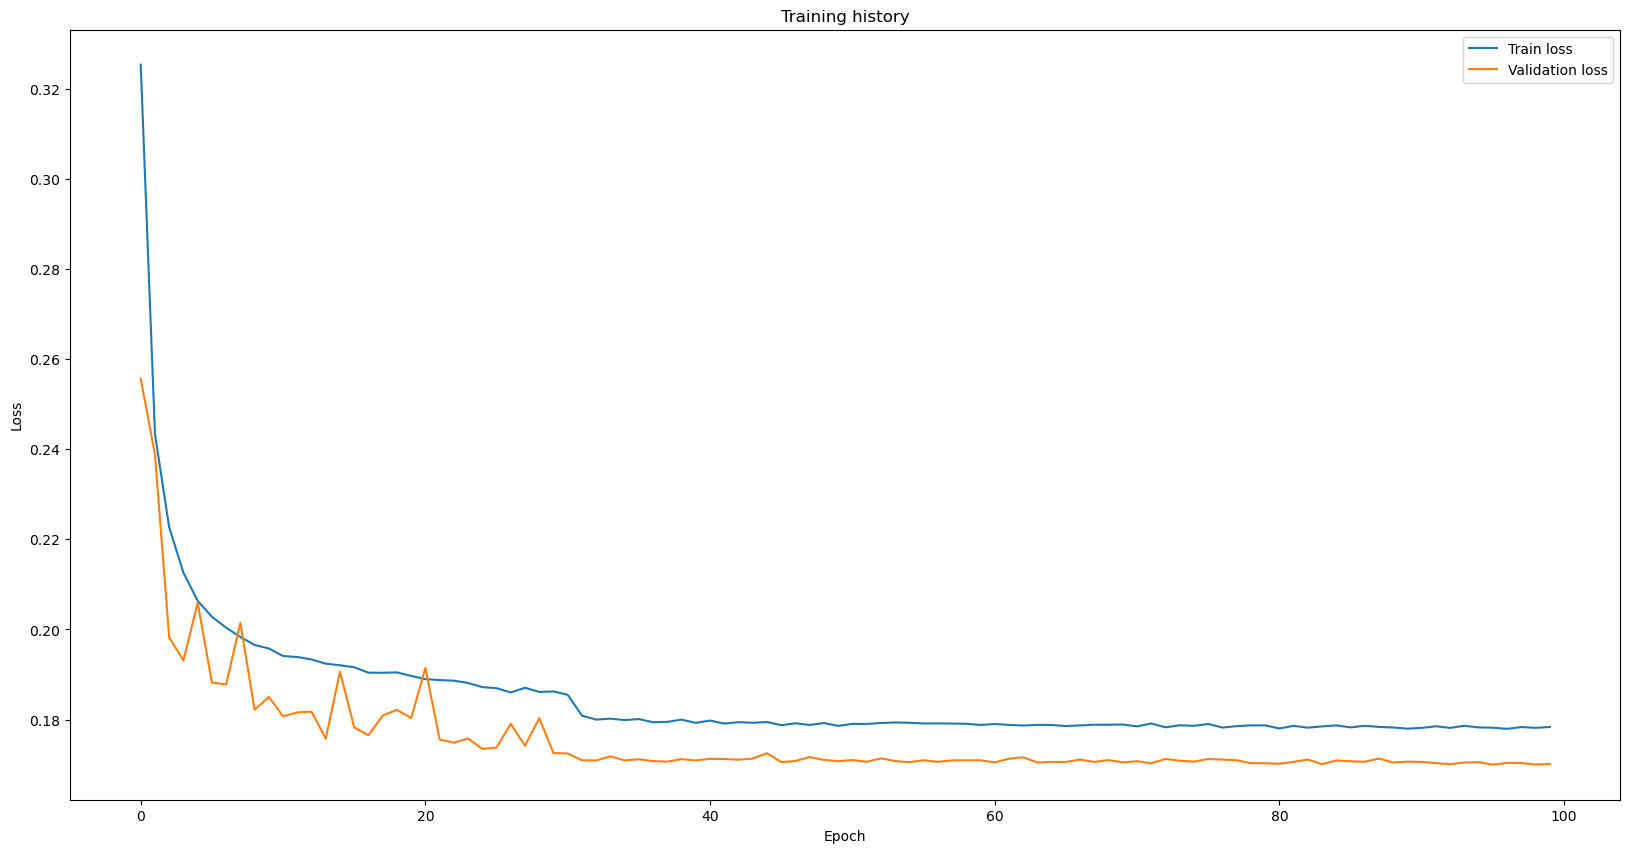

In [10]:
seeds_dir='initial_data/new_sw_10000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2920 - val_loss: 0.1655 - learning_rate: 0.0010
Epoch 2/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1676 - val_loss: 0.1375 - learning_rate: 0.0010
Epoch 3/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1466 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 4/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1343 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 5/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1245 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 6/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1191 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 7/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1175 - val_loss: 0.1005 - learning_rate: 0.0010
Epoch 8/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.1137 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 9/100
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step 

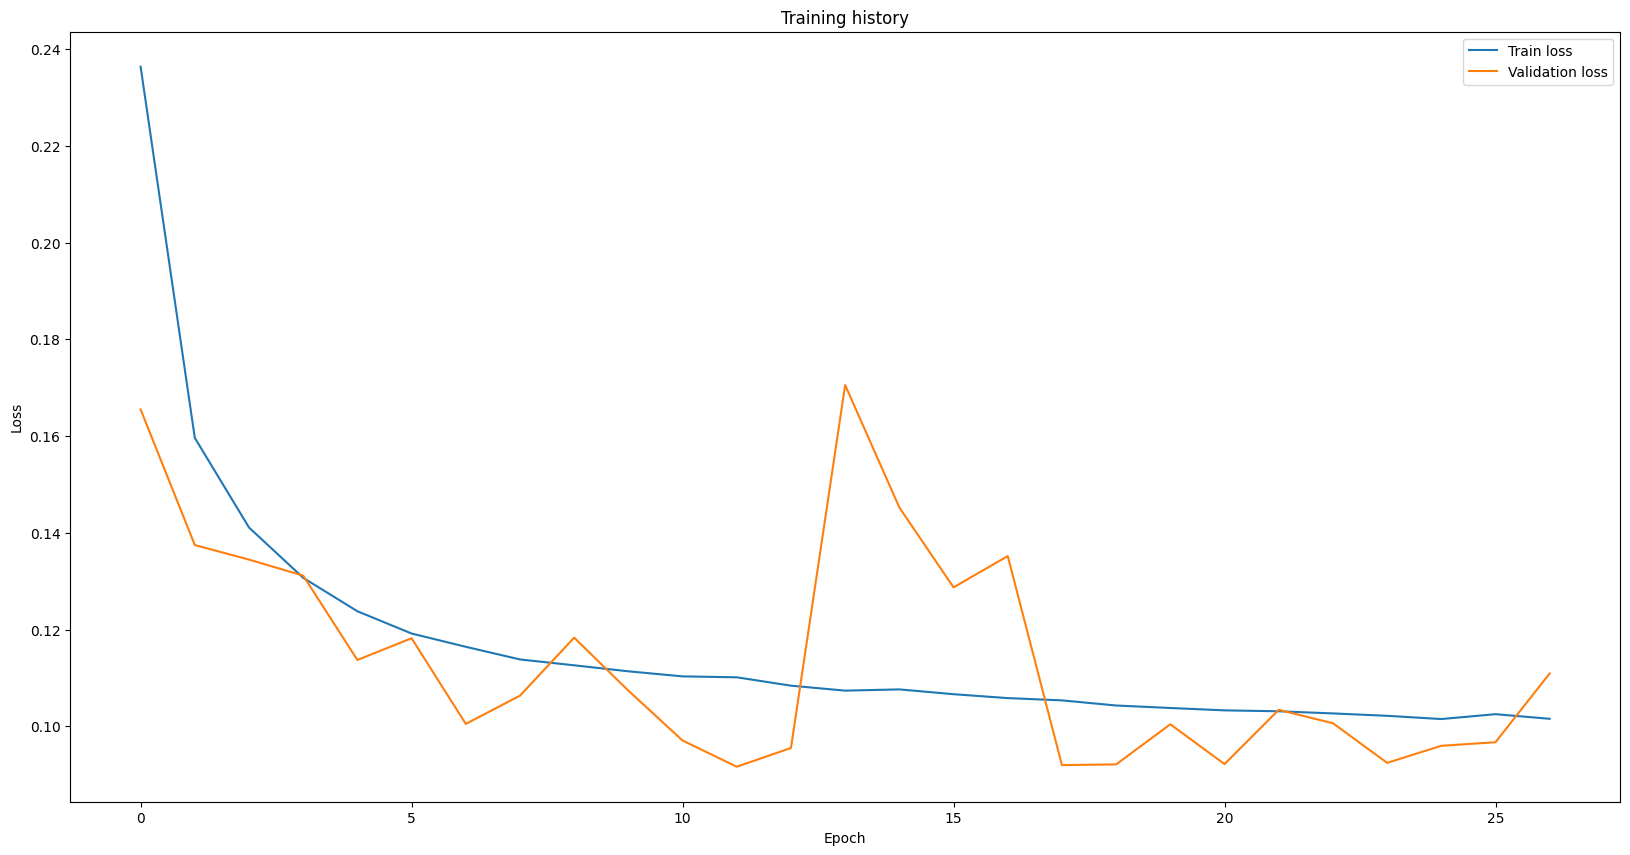

In [7]:
seeds_dir='initial_data/new_sw_50000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )


Training LSTM model on seeds...
Epoch 1/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.2052 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 2/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1320 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 3/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1183 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 4/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1116 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 5/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1078 - val_loss: 0.1068 - learning_rate: 0.0010
Epoch 6/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1044 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 7/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1019 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 8/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.0995 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 9/100
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 36s 1

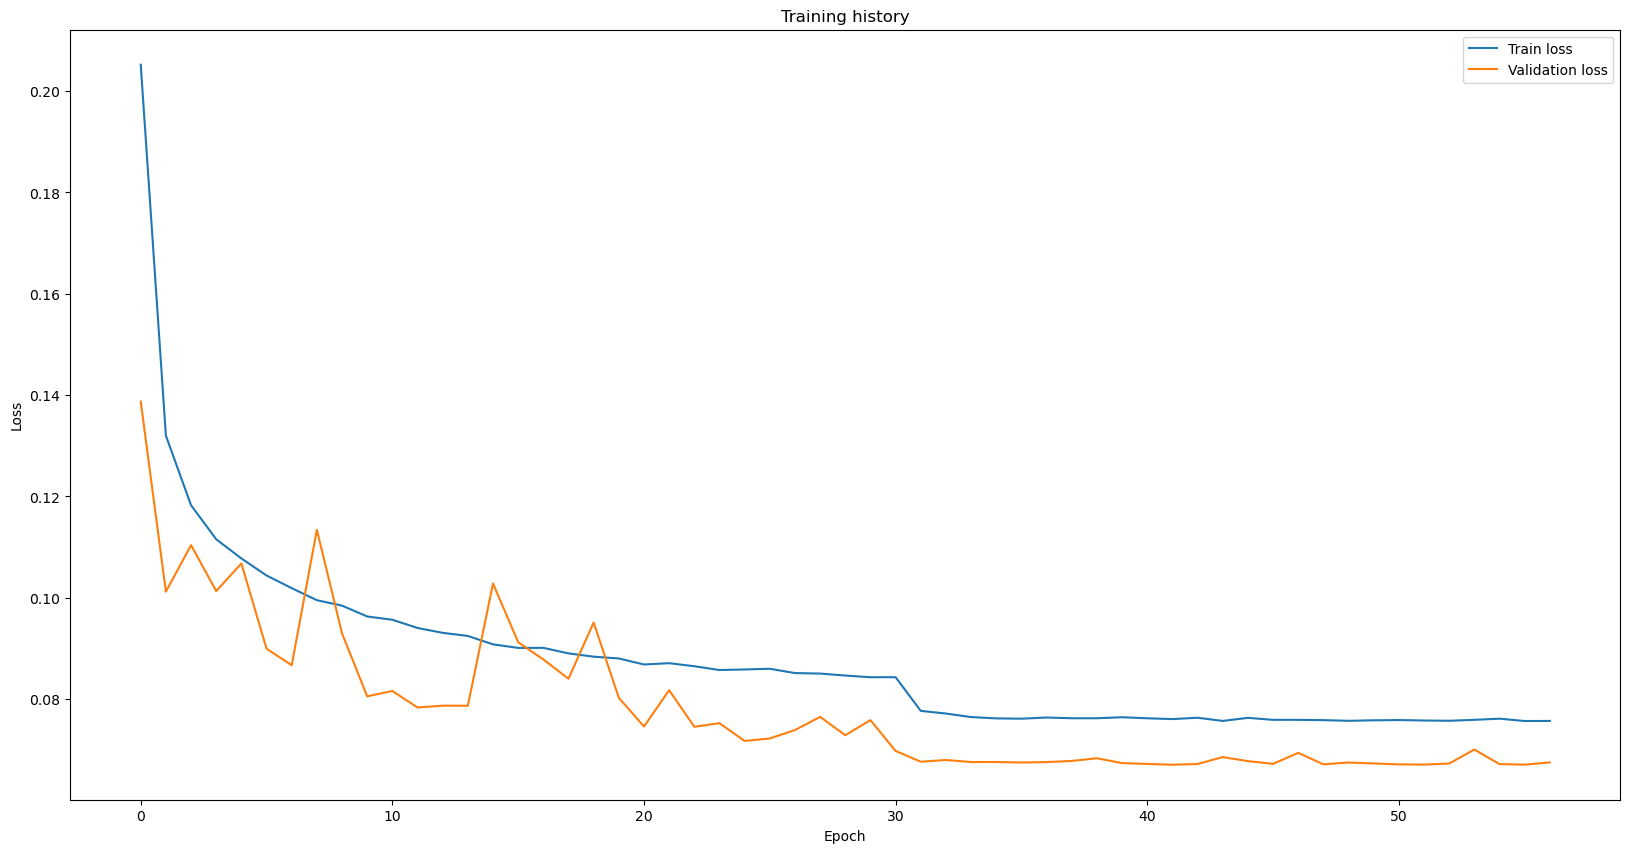

In [11]:
seeds_dir='initial_data/new_sw_100000/'
model_file = seeds_dir+'lstm_day_E_for_seir.keras'
scaler_file = seeds_dir+'lstm_day_E_for_seir.pkl'

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
window_size = 7

model, scaler, _ = train_and_save_model(
        seeds_dir,
        df_seeds_n,
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size,
    is_filename=True
    )
